# Exercise VIII: K-Means Clustering and PCA

## Iris Dataset

Let's start things off with a simple application of our subject material on the iris dataset to better understand our workflow and the relevant metrics.

### Set up

In [1]:
import pandas as pd

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

data = load_iris(as_frame=True)

X_iris, y_iris = data.data, data.target
y_iris = y_iris.replace(
    {index: name
     for index, name in enumerate(data["target_names"])})

# Feature scaling
scaler = StandardScaler()
X_iris = scaler.fit_transform(X_iris.loc[:, :])

### Dimensionality Reduction using [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis)

In [2]:
from sklearn.decomposition import PCA

iris_pca = PCA(n_components=X_iris.shape[1])
_ = iris_pca.fit(X_iris)

Let's try and evaluate how well did PCA manage to find small number of components to explain the variance:

In [3]:
from typing import Union

DEFAULT_FIG_KWARGS = {"figsize": (9, 6)}
DEFAULT_COMPONENT_AX_KWARGS = {
    "color": "purple",
    "linewidth": 2,
    "label": "Individual Component"
}
DEFAULT_CUMULATIVE_AX_KWARGS = {
    "color": "orange",
    "linewidth": 2,
    "label": "Cumulative"
}
DEFAULT_CUSTOMIZATIONS = {
    "title": "Explained Variance Ratio by Number of Principal Components",
    "xlabel": "Number of Principal Components",
    "ylabel": "Explained Variance Ratio"
}
DEFAULT_LEGEND_LOCATION = (0.85, 0.7)


def organize_kwargs(user_kwargs: Union[dict, None],
                    default_kwargs: dict = None) -> dict:
    """
    Update default keyword argument configuration with user provided
    configuration.
    
    Parameters
    ----------
    user_kwargs: Union[dict, None]
        Dictionary of user provided keyword argument configurations, or
        None
    default_kwargs: dict
        Default keyword argument configuration to be updated with user
        configuration
    
    Returns
    -------
    dict
        Complete keyword argument configuration
    """
    kwargs = user_kwargs or {}
    default_kwargs = default_kwargs or {}
    return {**default_kwargs, **kwargs}


def plot_explained_variance_ratio(
        pca: PCA,
        fig_kwargs: dict = None,
        component_ax_kwargs: dict = None,
        cumulative_ax_kwargs: dict = None,
        customizations: dict = None,
        legend_location: tuple = DEFAULT_LEGEND_LOCATION) -> tuple:
    """
    Plot explained variance by component number for a fitted PCA estimator.
    
    Parameters
    ----------
    pca : PCA
        Fitted PCA model
    fig_kwargs : dict
        Keyword arguments passed to the created figure
    component_ax_kwargs : dict
        Keyword arguments passed in the explained variance by individual
        component plot call
    cumulative_ax_kwargs : dict
        Keyword arguments passed in the cumulative explained variance by
        component plot call
    customizations : dict
        Keyword arguments passed to the axis' `set()` method
    legend_location: Tuple(float, float)
        Legend location within figure
    
    Returns
    -------
    Tuple(Figure, Axes)
        Create figure and axes
    """
    # Prepare figure and axes kwargs
    fig_kwargs = organize_kwargs(fig_kwargs, DEFAULT_FIG_KWARGS)
    component_ax_kwargs = organize_kwargs(component_ax_kwargs,
                                          DEFAULT_COMPONENT_AX_KWARGS)
    cumulative_ax_kwargs = organize_kwargs(cumulative_ax_kwargs,
                                           DEFAULT_CUMULATIVE_AX_KWARGS)
    customizations = organize_kwargs(customizations, DEFAULT_CUSTOMIZATIONS)

    # Create figure
    fig, ax = plt.subplots(**fig_kwargs)
    x_range = range(1, pca.n_components_ + 1)

    # Plot explained variance ratio by component
    ax.plot(x_range, pca.explained_variance_ratio_, **component_ax_kwargs)

    # Plot cumulative explained variance
    cumulative_sum = np.cumsum(pca.explained_variance_ratio_)
    ax.plot(x_range, cumulative_sum, **cumulative_ax_kwargs)

    #
    # Customizations
    #
    ax.set(**customizations)

    # Add legend
    fig.legend(bbox_to_anchor=legend_location)

    # Fix x-axis tick labels to show integers
    ax.set_xticks(x_range)
    ax.set_xticklabels(x_range)

    return fig, ax

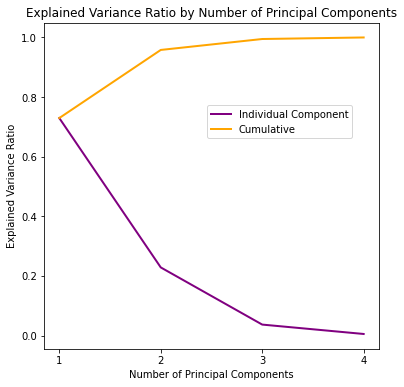

In [4]:
import matplotlib.pyplot as plt
import numpy as np

fig_kwargs = {"figsize": (6, 6)}
iris_explained_variance_fig, iris_explained_variance_ax = plot_explained_variance_ratio(
    iris_pca, fig_kwargs=fig_kwargs)

In [5]:
from myst_nb import glue

glue("iris_explained_variance_fig", iris_explained_variance_fig, display=False)

In [6]:
def create_explained_variance_df(pca: PCA) -> pd.DataFrame:
    """
    Create a formatted dataframe to display the plot's information conveniently
    
    Parameters
    ----------
    pca : PCA
        Fitted PCA model
        
    Returns
    -------
    pd.DataFrame
        Explained variance (per component and cumulative)
    """
    results_dict = {
        "Individual Component": pca.explained_variance_ratio_,
        "Cumulative": np.cumsum(pca.explained_variance_ratio_)
    }
    df = pd.DataFrame(results_dict, index=range(1, pca.n_components_ + 1))
    df.index.name = "# Components"
    return df


explained_variance_df = create_explained_variance_df(iris_pca)
explained_variance_df_repr = explained_variance_df.style.set_table_styles([
    dict(selector="th", props=[("font-size", "12px")]),
    dict(selector="td", props=[("font-size", "12px")]),
])

glue("iris_explained_variance_df", explained_variance_df_repr, display=False)

````{panels}
```{glue:figure} iris_explained_variance_df
    :figwidth: 300px
    :name: "iris-explained_variance-df"
```
---
```{glue:figure} iris_explained_variance_fig
    :figwidth: 300px
    :name: "iris-explained_variance-fig"
```
````

In [7]:
iris_explained_variance_2 = explained_variance_df.loc[2, "Cumulative"] * 100
iris_explained_variance_3 = explained_variance_df.loc[3, "Cumulative"] * 100

glue("iris_explained_variance_2", iris_explained_variance_2, display=False)
glue("iris_explained_variance_3", iris_explained_variance_3, display=False)

We've managed to capture {glue:text}`iris_explained_variance_2:.2f`% of the variance using only 2 components, and {glue:text}`iris_explained_variance_3:.2f`% percent using 3, not bad at all!

To calculate the coordinates of the dataset in the dimensions of the calculated principal components, we have to call [`tranform()`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.transform):

In [8]:
X_iris_reduced = iris_pca.transform(X_iris)
X_iris_reduced.shape

(150, 4)

```{note}
As with many other classes that implement this general procedure, `sklearn` also provides a [`fit_transform()`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.fit_transform) function to do both more conveniently.
```

Fortunately, 2 and 3 dimensions are also simple enough to visualize:

In [9]:
from ipywidgets import interact

x1, x2, x3 = X_iris_reduced[:, :3].T


def plot_3d_scatter(elev=10, azim=-90):
    fig = plt.figure(figsize=(8, 8))
    ax_3d = fig.add_subplot(111, projection="3d")
    ax_3d.scatter(x1, x2, x3)
    ax_3d.set(title="Iris Dataset Projected Over 3 Dimensions Using PCA",
              xlabel="Principal Component #1",
              ylabel="Principal Component #2",
              zlabel="Principal Component #3")
    ax_3d.view_init(elev, azim)


_ = interact(plot_3d_scatter)

interactive(children=(IntSlider(value=10, description='elev', max=30, min=-10), IntSlider(value=-90, descripti…

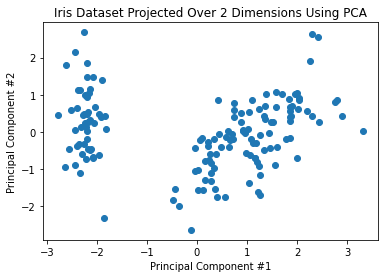

In [10]:
iris_2d_fig, iris_2d_ax = plt.subplots(figsize=(6, 4))
iris_2d_ax.scatter(X_iris_reduced[:, 0], X_iris_reduced[:, 1])
_ = iris_2d_ax.set(title="Iris Dataset Projected Over 2 Dimensions Using PCA",
                   xlabel="Principal Component #1",
                   ylabel="Principal Component #2")

Ah, we can already guess the `setosa` class to be that discernible cloud on the left of both dimensionality-reduced scatters.

### [K-means](https://en.wikipedia.org/wiki/K-means_clustering) Clustering

In [11]:
from sklearn.cluster import KMeans

N_IRIS_CLASSES = 3

iris_kmeans = KMeans(n_clusters=N_IRIS_CLASSES, random_state=0)

iris_labels_4 = iris_kmeans.fit_predict(X_iris_reduced[:, :4])
iris_labels_3 = iris_kmeans.fit_predict(X_iris_reduced[:, :3])
iris_labels_2 = iris_kmeans.fit_predict(X_iris_reduced[:, :2])
iris_labels_1 = iris_kmeans.fit_predict(X_iris_reduced[:, :1].reshape(-1, 1))

In [12]:
y_iris_labels = y_iris.replace({"setosa": 1, "versicolor": 2, "virginica": 0})

classification_success_3 = y_iris_labels == iris_labels_3


def plot_3d_scatter(elev=10, azim=-90):
    fig = plt.figure(figsize=(12, 12))
    ax_3d = fig.add_subplot(111, projection="3d")
    # Plot correct labels
    ax_3d.scatter(x1[classification_success_3],
                  x2[classification_success_3],
                  x3[classification_success_3],
                  s=60,
                  c=iris_labels_3[classification_success_3])
    # Plot incorrect labels
    ax_3d.scatter(x1[~classification_success_3],
                  x2[~classification_success_3],
                  x3[~classification_success_3],
                  c=iris_labels_3[~classification_success_3],
                  s=60,
                  marker="x")
    # Customization
    ax_3d.set(xlabel="Principal Component #1",
              ylabel="Principal Component #2",
              zlabel="Principal Component #3")
    ax_3d.view_init(elev, azim)
    ax_3d.set_title("Iris Dataset Projected Over 3 Dimensions Using PCA")


_ = interact(plot_3d_scatter)

interactive(children=(IntSlider(value=10, description='elev', max=30, min=-10), IntSlider(value=-90, descripti…

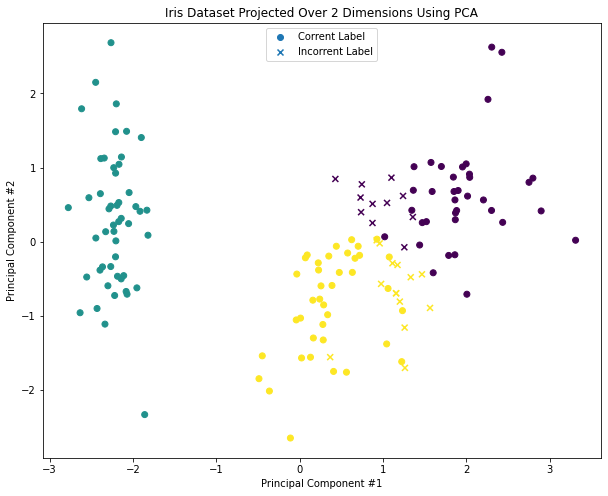

In [13]:
classification_success_2 = y_iris_labels == iris_labels_2

X_success_2 = X_iris_reduced[classification_success_2]
X_misclassified_2 = X_iris_reduced[~classification_success_2]

iris_2d_fig, iris_2d_ax = plt.subplots(figsize=(10, 8))
# Plot correct labels
iris_2d_ax.scatter(X_success_2[:, 0],
                   X_success_2[:, 1],
                   c=iris_labels_2[classification_success_2],
                   label="Corrent Label")
# Plot incorrect labels
iris_2d_ax.scatter(X_misclassified_2[:, 0],
                   X_misclassified_2[:, 1],
                   c=iris_labels_2[~classification_success_2],
                   marker="x",
                   label="Incorrent Label")
iris_2d_ax.legend(loc="upper center")
_ = iris_2d_ax.set(title="Iris Dataset Projected Over 2 Dimensions Using PCA",
                   xlabel="Principal Component #1",
                   ylabel="Principal Component #2")

#### Clustering Evaluation

How do you think we did relative to the baseline (clustering using all 4 features) as we reduced the dimensionality of the dataset?

In [14]:
from sklearn.metrics import accuracy_score
from typing import Iterable

DEFAULT_FIGURE_KWARGS = {"figsize": (10, 5)}
DEFAULT_AXES_KWARGS = {"marker": "o"}


def plot_accuracy(classification_labels: Iterable,
                  true_labels: pd.Series,
                  fig_kwargs: dict = None,
                  ax_kwargs: dict = None) -> tuple:
    fig_kwargs = organize_kwargs(fig_kwargs, DEFAULT_FIGURE_KWARGS)
    ax_kwargs = organize_kwargs(ax_kwargs, DEFAULT_AXES_KWARGS)
    scores = [
        accuracy_score(labels, true_labels) for labels in classification_labels
    ]

    # Plot accuracy scores
    fig, ax = plt.subplots(**fig_kwargs)
    x_range = range(1, len(scores) + 1)
    ax.plot(x_range, scores, **ax_kwargs)
    ax.set(title="Accuracy by Number of Principal Components",
           xlabel="Number of Principal Components",
           ylabel="Accuracy Score",
           xticks=x_range,
           xticklabels=x_range)
    return fig, ax

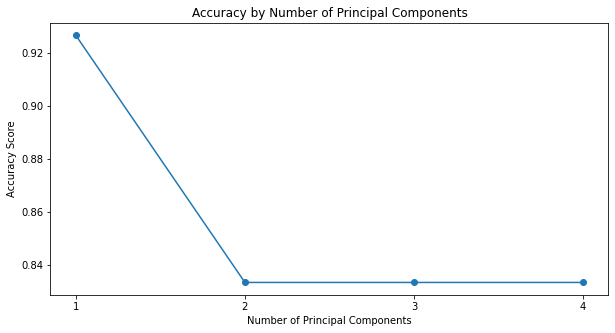

In [15]:
classification_labels = (iris_labels_1, iris_labels_2, iris_labels_3,
                         iris_labels_4)
_ = plot_accuracy(classification_labels, y_iris_labels)

Amazingly, dropping the dimensionality of our dataset did not effect our ability to identify clusters of iris classes at all for 3 or 2 dimensions, but actually **increased** our accuracy in 1 dimension.

`sklearn`'s `metrics` module also provides us with the `silhouette_score` metric for evaluating the degree of separation between the clusters:

In [16]:
from sklearn.metrics import silhouette_score

DEFAULT_FIGURE_KWARGS = {"figsize": (10, 5)}
DEFAULT_AXES_KWARGS = {"marker": "o"}
DEFAULT_CUSTOMIZATIONS = {
    "title": "Silhouette Score by Number of Principal Components",
    "xlabel": "Number of Principal Components",
    "ylabel": "Silhouette Score"
}


def plot_silhouette_scores(model: KMeans,
                           X: np.ndarray,
                           true_labels: pd.Series,
                           fig_kwargs: dict = None,
                           ax_kwargs: dict = None,
                           customizations: dict = None) -> tuple:
    fig_kwargs = organize_kwargs(fig_kwargs, DEFAULT_FIGURE_KWARGS)
    ax_kwargs = organize_kwargs(ax_kwargs, DEFAULT_AXES_KWARGS)
    customizations = organize_kwargs(customizations, DEFAULT_CUSTOMIZATIONS)
    scores = []
    x_range = range(1, X.shape[1] + 1)
    for i in x_range:
        X_subset = X[:, :i]
        if i == 1:
            X_subset = X_subset.reshape(-1, 1)
        labels = model.fit_transform(X_subset)
        score = silhouette_score(labels, true_labels)
        scores.append(score)
    fig, ax = plt.subplots(**fig_kwargs)
    ax.plot(x_range, scores, **ax_kwargs)
    ax.set(**customizations)
    return fig, ax

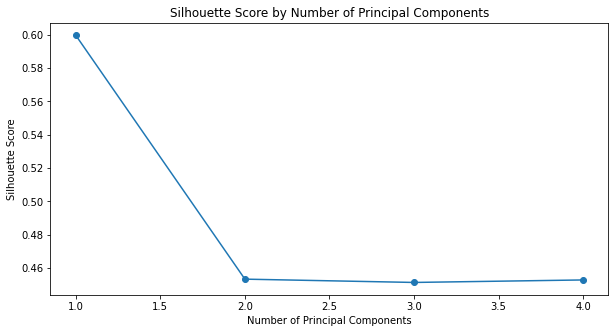

In [17]:
_ = plot_silhouette_scores(iris_kmeans, X_iris_reduced, y_iris_labels)

## ASD Subtypes Classification

So, now we know how to implement PCA and K-means clustering using `sklearn`. Next, we will try and explore the possibility of identifying ASD subtypes using  and  on the [ABIDE II](http://fcon_1000.projects.nitrc.org/indi/abide/abide_II.html) dataset, again, based on [Prof. Tal Yarkoni](https://talyarkoni.org/)'s workshop in  the [NeuroHackademy](https://neurohackademy.org/) 2020 (available [here](https://github.com/neurohackademy/nh2020-curriculum/tree/master/tu-machine-learning-yarkoni)).

First, as always, we have to load the data and clean it up a little bit:

In [18]:
TSV_URL = "https://raw.githubusercontent.com/neurohackademy/nh2020-curriculum/master/tu-machine-learning-yarkoni/data/abide2.tsv"
data = pd.read_csv(TSV_URL, delimiter="\t")

# Clean
IGNORED_COLUMNS = ["age_resid", "sex"]
REPLACE_DICT = {"group": {1: "ASD", 2: "Control"}}
data.drop(columns=IGNORED_COLUMNS, inplace=True)
data.replace(REPLACE_DICT, inplace=True)

This time, however, we're only interested in ASD positive observations:

In [19]:
from sklearn.preprocessing import StandardScaler

asd_positive = data["group"] == "ASD"

# Feature matrix
X = data[asd_positive].filter(regex="^fs").copy()

# Feature scaling
scaler = StandardScaler()
X.loc[:, :] = scaler.fit_transform(X.loc[:, :])

X

,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,fsArea_L_V3_ROI,fsArea_L_V4_ROI,fsArea_L_V8_ROI,fsArea_L_4_ROI,fsArea_L_3b_ROI,fsArea_L_FEF_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
0,-0.731130,1.179502,-0.584671,-1.308675,-1.206924,-0.816245,0.154402,-0.258584,-0.278607,1.829968,...,2.186101,-0.720148,0.369192,-0.522160,0.104033,0.704565,0.793778,-0.167456,-0.420926,0.018466
1,-0.564107,-0.540347,-0.584671,-0.931977,-0.671912,-0.283729,-0.011425,-1.119532,-1.417950,-1.229992,...,0.701741,0.676280,0.889796,0.150595,1.071329,0.863305,0.607744,-0.046772,-0.292914,0.378526
3,0.496296,0.606219,0.385436,0.228145,0.571085,0.272350,-0.425994,0.257985,0.733599,-0.256369,...,2.151207,0.293831,0.110449,0.873185,0.269181,-0.016980,0.868708,0.029759,0.437027,0.229536
5,-0.206755,2.383396,0.185708,-0.402415,-0.619618,-0.387405,0.336812,1.249947,1.652897,0.865617,...,1.260053,0.015330,1.818779,-0.045971,-0.388462,0.623752,0.553485,1.837080,0.848299,-1.327417
6,0.768194,-1.199622,1.084483,0.907840,1.029667,0.856704,-1.072720,-0.415800,-0.205259,0.114536,...,-0.562516,0.201651,0.880444,-0.081962,0.334060,0.381312,-1.353356,1.919499,0.197345,0.400875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,0.203034,-0.311034,0.043045,0.263631,-0.671912,-1.334624,-2.034519,0.643540,-0.083012,1.134522,...,2.097523,-0.004283,-0.759303,-0.045971,0.186607,0.101353,-0.751332,0.547819,0.690327,-0.254684
995,-0.869021,-0.081721,-1.226653,-1.532510,-1.118425,-0.948196,-0.459159,-0.333449,-1.036539,0.012537,...,0.036060,0.517417,0.309962,0.114604,-0.653879,-0.634623,-1.022630,0.050364,-1.649296,0.592080
996,-2.694622,0.075932,0.841957,-2.736307,-2.997000,-2.574020,-1.603368,-0.756436,-0.567110,-0.682908,...,0.959423,0.825337,-0.001778,-0.599679,0.979907,1.873468,0.196921,-0.514792,1.842434,0.418257
998,0.517659,1.365819,2.682306,1.074351,1.230799,0.705903,-0.011425,-0.176232,0.293509,2.108146,...,0.366216,-0.002321,0.515709,0.037085,1.153903,0.020540,1.855717,0.609633,-0.603411,0.778318


### Principal Component Analysis (PCA)

We will use PCA to try and "capture" as much of the variance of our 1,440 features using a limited number of principal components.

In [20]:
from sklearn.decomposition import PCA

N_COMPONENTS = 20

pca = PCA(n_components=N_COMPONENTS)
X_reduced = pca.fit_transform(X)

Let's try and evaluate how well did PCA manage to find small number of components to explain the variance:

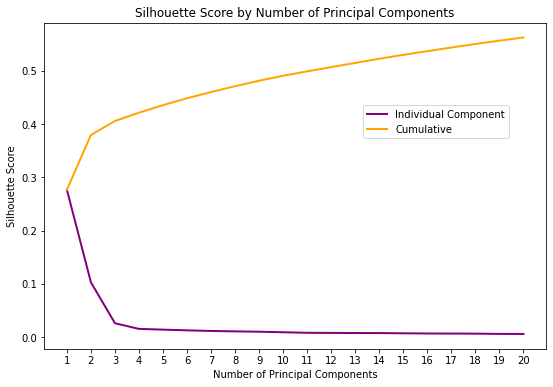

In [21]:
_ = plot_explained_variance_ratio(pca)

In [22]:
k_3_explained = f"{np.cumsum(pca.explained_variance_ratio_)[3] * 100:.2f}"

glue("k_3_explained", k_3_explained, display=False)

It seems like the added value of using more than 2 or 3 components is relatively negligible, with 3 components explaining a total of {glue:text}`k_3_explained:.2f`% of the total variance. 

### K-Means Clustering

In [23]:
from sklearn.cluster import KMeans

X_3 = X_reduced[:, :3]
MAX_N_CLUSTERS = 10

models = [KMeans(n_clusters=i).fit(X_3) for i in range(2, MAX_N_CLUSTERS + 1)]

#### Clustering Evaluation

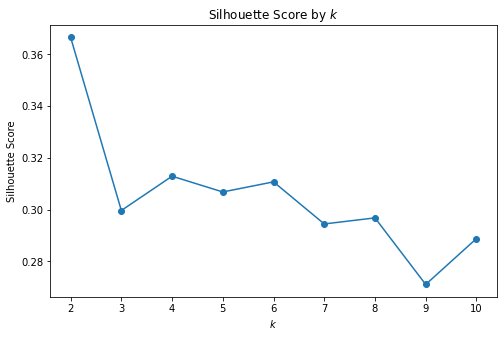

In [24]:
from sklearn.metrics import silhouette_score

scores = [silhouette_score(X_3, model.labels_) for model in models]

scores_fig, scores_ax = plt.subplots(figsize=(8, 5))
scores_ax.plot(range(2, MAX_N_CLUSTERS + 1), scores, "o-")
_ = scores_ax.set(title="Silhouette Score by $k$",
                  xlabel="$k$",
                  ylabel="Silhouette Score")

It seems like the best degree of separation was obtained for $k=2$. Let's visualize the two clusters and to obtain some qualitative understanding of how well (or badly) our model did:

In [25]:
from ipywidgets import interact

x1, x2, x3 = X_3.T


def plot_3d_scatter(elev=10, azim=-90):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(x1, x2, x3, s=15, marker="o", c=models[0].labels_)
    ax.set(xlabel="Principal Component #1",
           ylabel="Principal Component #2",
           zlabel="Principal Component #3")
    ax.view_init(elev, azim)


_ = interact(plot_3d_scatter)

interactive(children=(IntSlider(value=10, description='elev', max=30, min=-10), IntSlider(value=-90, descripti…

Indeed, it seems our model's ability to cluster ASD subtypes using three principal components is rather poor.